In [1]:
import keras
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from unicodedata import normalize as unicodeNormalize

In [2]:

df = pd.read_csv('../fake_or_real_news.csv')
df['merged_text'] = df['title'] + '. ' + df['text']
df.loc[df['label'] == 'REAL', 'target'] = 0
df.loc[df['label'] == 'FAKE', 'target'] = 1

df_pick = df[['merged_text', 'target']]
df.head()

,Unnamed: 0,title,text,label,merged_text,target
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear. Daniel Greenfiel...,1.0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,1.0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy. U...,0.0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...,1.0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...,0.0


1. Load data as train and test data.   
  a. add Title to text and create final text, label ordered pair.  
  b. Split 80-20 into train and test datasets.

In [4]:
training_data = df_pick.sample(frac=0.8, random_state=25)
testing_data = df_pick.drop(training_data.index)

print(training_data.shape)
print(testing_data.shape)

(5068, 2)
(1267, 2)


In [5]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_data['merged_text'].values, tf.string),
            tf.cast(training_data['target'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(testing_data['merged_text'].values, tf.string),
            tf.cast(testing_data['target'].values, tf.int32)
        )
    )
)
BUFFER_SIZE = 10000
BATCH_SIZE = 64
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2022-04-19 00:47:07.786820: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 00:47:09.875253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10779 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:05:00.0, compute capability: 3.7


In [7]:
for example, label in training_dataset.take(1):
  print('texts: ', example.numpy()[:1])
  print('labels: ', label.numpy()[:1])

texts:  [b'Dying out: Wild animal numbers could fall by 67% from 1970-2020, study says. RT October 27, 2016 \nThe number of wild animals on Earth could fall by more than two-thirds in the 50 years to 2020, according to a new report which places the blame on the destruction of habitats, hunting and pollution. The forecast could lead to major consequences for humans. \nThe Living Planet Report 2016 says that animal losses are on track to reach 67 percent in the 50 years to 2020. The report\xe2\x80\x99s authors also took into consideration a recent trend in animal population decline, citing a 58 percent plummet between 1970 and 2012. \nThe researchers analyzed the changing presence of 14,152 monitored populations of the 3,706 vertebrate species \xe2\x80\x93 mammals, birds, fish, amphibians and reptiles among them. \nAccording to the paper, the biggest cause of the plummeting animal populations is the destruction of wilderness areas by farming and logging. Pollution was also mentioned as a

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(training_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is',
       'for', 'on', 'as', 'it', 'with', 'he', 'was', 'are', 'be', 'this'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,  57,   1, ...,   0,   0,   0],
       [  2,   1,   1, ...,   0,   0,   0],
       [614,   2, 566, ...,   0,   0,   0]])

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
sample_text = ('''Poll: 71 percent of Dems think Clinton should keep running even if indicted. A strong majority of Democratic voters think Hillary 
               Clinton should keep running for president even if she is charged with 
               a felony in connection with her private email use while secretary of state, according to a new poll.''')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

2022-04-19 00:47:29.212588: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


[0.00824939]


In [13]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(training_dataset, epochs=20, callbacks = [callback],
                    validation_data=test_dataset)

Epoch 1/20
80/80 [==============================] - 39s 432ms/step - loss: 0.6894 - accuracy: 0.5024 - val_loss: 0.6851 - val_accuracy: 0.4933
Epoch 2/20
80/80 [==============================] - 33s 405ms/step - loss: 0.6714 - accuracy: 0.5270 - val_loss: 0.6213 - val_accuracy: 0.6740
Epoch 3/20
80/80 [==============================] - 33s 410ms/step - loss: 0.5998 - accuracy: 0.6855 - val_loss: 0.5739 - val_accuracy: 0.6630
Epoch 4/20
80/80 [==============================] - 32s 404ms/step - loss: 0.5182 - accuracy: 0.7486 - val_loss: 0.4298 - val_accuracy: 0.8145
Epoch 5/20
80/80 [==============================] - 32s 401ms/step - loss: 0.5009 - accuracy: 0.7703 - val_loss: 0.3809 - val_accuracy: 0.8350
Epoch 6/20
80/80 [==============================] - 32s 400ms/step - loss: 0.4167 - accuracy: 0.8392 - val_loss: 0.3961 - val_accuracy: 0.8248
Epoch 7/20
80/80 [==============================] - 33s 407ms/step - loss: 0.4242 - accuracy: 0.8362 - val_loss: 0.4044 - val_accuracy: 0.8287

In [15]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7124930001795292)

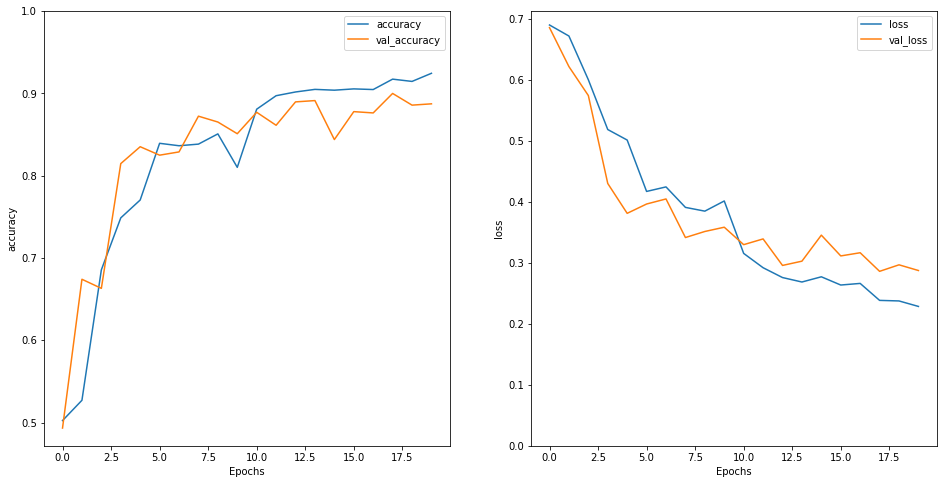

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [17]:
model.evaluate(test_dataset)

20/20 [==============================] - 3s 161ms/step - loss: 0.2872 - accuracy: 0.8871


[0.2871758043766022, 0.8871349692344666]